## Plane Delays & Calculations

After the data cleaning process done in , let's go ahead with the analysis!

### CRISP-DM Framework

* Business Problem: 
* Data Understanding: What the data set is
* Data Preparation: All Data Cleaning, inc treatment of missing Data, NaNs, zeros, transforms
* Modelling: The Modelling Workflow, models used and feature transforms / engineering
* Evaulation: Evaluation of the Final Model vs Baseline Model
* Deployment: Results generated by the model

### CRISP-DM Framework: Business Problem:
* Identify Factors that could help Reduce Flight Cancellations / Delays for intenal US departing from Wisconsin.
* Save money / stress, etc.

### What the data set is:

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

The dataset was sourced from Kaggle.

https://www.kaggle.com/usdot/flight-delays

In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## Importing `.csv`

In [3]:
df = pd.read_csv('wisconsin.csv')
df.head(2)
df.drop(df.columns[0], axis=1, inplace=True)

In [4]:
# all years are 2015
del df['YEAR']

In [5]:
df.head(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,OO,3423,N170SY,MKE,SEA,1605,1603.0,-2.0,11.0,1614.0,260.0,254.0,231.0,1694,1805.0,12.0,1825,1817.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
1,7,2,4,OO,3423,N171SY,MKE,SEA,1605,1600.0,-5.0,14.0,1614.0,260.0,258.0,234.0,1694,1808.0,10.0,1825,1818.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
2,7,3,5,OO,3423,N170SY,MKE,SEA,1605,1605.0,0.0,17.0,1622.0,260.0,284.0,257.0,1694,1839.0,10.0,1825,1849.0,24.0,0,0,NaN,24.0,0.0,0.0,0.0,0.0,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
3,7,4,6,OO,3423,N173SY,MKE,SEA,1605,1558.0,-7.0,12.0,1610.0,260.0,247.0,224.0,1694,1754.0,11.0,1825,1805.0,-20.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
4,7,5,7,OO,3423,N171SY,MKE,SEA,1605,1600.0,-5.0,11.0,1611.0,260.0,238.0,221.0,1694,1752.0,6.0,1825,1758.0,-27.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
5,7,6,1,OO,3423,N173SY,MKE,SEA,1605,1603.0,-2.0,14.0,1617.0,260.0,260.0,234.0,1694,1811.0,12.0,1825,1823.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
6,7,7,2,OO,3423,N171SY,MKE,SEA,1605,1602.0,-3.0,14.0,1616.0,260.0,269.0,245.0,1694,1821.0,10.0,1825,1831.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
7,7,8,3,OO,3423,N173SY,MKE,SEA,1605,1556.0,-9.0,11.0,1607.0,260.0,251.0,229.0,1694,1756.0,11.0,1825,1807.0,-18.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
8,7,9,4,OO,3423,N171SY,MKE,SEA,1605,1600.0,-5.0,17.0,1617.0,260.0,249.0,224.0,1694,1801.0,8.0,1825,1809.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
9,7,10,5,OO,3423,N173SY,MKE,SEA,1605,1559.0,-6.0,11.0,1610.0,260.0,272.0,252.0,1694,1822.0,9.0,1825,1831.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931


In [6]:
departure_delay = df['DEPARTURE_DELAY']

In [7]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE'],
      dtype='object')

In [8]:
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].replace('nan', np.nan).fillna(0)
df['AIR_SYSTEM_DELAY'] = df['AIR_SYSTEM_DELAY'].replace('nan', np.nan).fillna(0)
df['SECURITY_DELAY'] = df['SECURITY_DELAY'].replace('nan', np.nan).fillna(0)
df['AIRLINE_DELAY'] = df['AIRLINE_DELAY'].replace('nan', np.nan).fillna(0)
df['LATE_AIRCRAFT_DELAY'] = df['LATE_AIRCRAFT_DELAY'].replace('nan', np.nan).fillna(0)
df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].replace('nan', np.nan).fillna(0)
df['DEPARTURE_DELAY'] = df['DEPARTURE_DELAY'].replace('nan', np.nan).fillna(0)
df['TAXI_OUT'] = df['TAXI_OUT'].replace('nan', np.nan).fillna(0)
df['WHEELS_OFF'] = df['WHEELS_OFF'].replace('nan', np.nan).fillna(0)
df['ELAPSED_TIME'] = df['ELAPSED_TIME'].replace('nan', np.nan).fillna(0)
df['AIR_TIME'] = df['AIR_TIME'].replace('nan', np.nan).fillna(0)
df['WHEELS_ON'] = df['WHEELS_ON'].replace('nan', np.nan).fillna(0)
df['TAXI_IN'] = df['TAXI_IN'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].replace('nan', np.nan).fillna(0)
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].replace('nan', np.nan).fillna(0)

In [9]:
df['DELAYED_TARGET'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)

In [10]:
# cancelled_2 = df[df['CANCELLED'] != 0]
# cancelled_2.info()

In [11]:
# delayed = df[df['DEPARTURE_DELAY'] > 0]
# delayed
df.head(2)
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE', 'DELAYED_TARGET'],
      dtype='object')

# Dataset exploration

## Visual exploration

In [12]:
# sns.jointplot('DEPARTURE_DELAY', 'SCHEDULED_DEPARTURE', data=df, kind='reg');

In [13]:
# sns.jointplot('DEPARTURE_DELAY','MONTH', data=df, kind='reg');

In [14]:
# sns.jointplot('DEPARTURE_DELAY','DAY_OF_WEEK', data=df, kind='reg');

# Feature selection

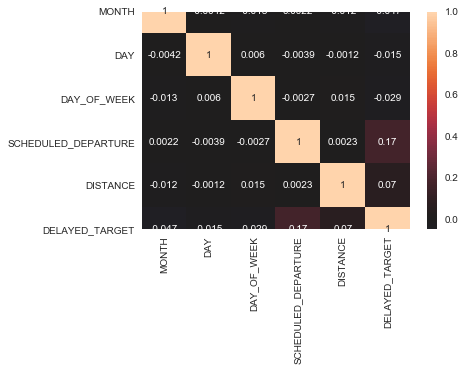

In [15]:
features = ['MONTH',                    
            'DAY',                      
            'DAY_OF_WEEK',                 
            'SCHEDULED_DEPARTURE',            
            'DISTANCE',
            'DELAYED_TARGET'
           ]


target = df['DEPARTURE_DELAY']
dfFeatures = df[features].copy()
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

In [16]:
dfFeatures

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DISTANCE,DELAYED_TARGET
0,7,1,3,1605,1694,0
1,7,2,4,1605,1694,0
2,7,3,5,1605,1694,0
3,7,4,6,1605,1694,0
4,7,5,7,1605,1694,0
...,...,...,...,...,...,...
51371,12,30,3,2144,67,1
51372,12,31,4,2123,67,0
51373,6,13,6,2200,114,1
51374,1,2,5,2000,701,0


In [17]:
### let's try some svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from sklearn.model_selection import train_test_split

In [18]:
dff = dfFeatures.iloc[:50000].copy()
dff.head(2)
dff.DELAYED_TARGET.value_counts()

0    36592
1    13408
Name: DELAYED_TARGET, dtype: int64

In [19]:
# sub sampling from the class to get around class imbalance issue 1/3 : 2/3 split

In [20]:
# setting up the problem
X = dff.drop('DELAYED_TARGET', axis=1)  
y = dff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='linear') #, C=0.1, cache_size=100)  
svclassifier.fit(X_train, y_train)

In [ ]:
y_pred = svclassifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

## Bigger sample size / load for analytics
dff_5000 = dfFeatures.iloc[:5000]
# setting up the problem
        X = dff_5000.drop('DELAYED_TARGET', axis=1)  
y = dff_5000['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
from sklearn.svm import SVC 
svclassifier = SVC(kernel='linear') #, C=0.1, cache_size=100)  
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

In [ ]:
del dff['DAY']
dff.head(1)

## Decision Tree Analysis
Work-in-progress will go here

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [ ]:
dff.head()

In [ ]:
# setting up the problem
X = dff.drop('DELAYED_TARGET', axis=1)  
y = dff['DELAYED_TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# One-hot encode the training data and show the resulting DataFrame with proper column names
ohe = OneHotEncoder()

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.head()

## Train the decision tree

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10)

clf.fit(X_train_ohe, y_train)

## Plot the decision tree

In [ ]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())a


In [ ]:
X_test_ohe = ohe.transform(X_test)
y_preds = clf.predict(X_test_ohe)

print('Accuracy: ', accuracy_score(y_test, y_preds))

In [ ]:
col_2 = ohe_df[ohe_df.columns[2],[1050]].unique()

In [ ]:
col_1

In [ ]:
z = dff.drop('DELAYED_TARGET', axis=1)
z
a = dff['DELAYED_TARGET']
a

In [ ]:
features = X.columns
target = y
target

In [ ]:
# from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

X = dff.drop('DELAYED_TARGET', axis=1)
y = dff['DELAYED_TARGET']

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X, y)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                feature_names=features,
                class_names=y, 
                rounded=True, 
                filled=True)

Using the VIF, we can assess the list of features we want to include in our model. We are still left with multicollinearity issues but the most obvious ones have been removed.

In [ ]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

# Baseline model

In [ ]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

## Linear regression model generation

In [ ]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

## Evaluating the baseline model

In [ ]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

As we can see above, our Rsquared value is just above 0.5 for our train dataset and just below 0.5 for our test dataset. This means the model fits the training dataset slighlty better than the test one. However, as we are using a Kfold method, the test dataset is a portion of the training dataset and each portion - or fold - is used sequentially as the test dataset. The 0.49 value is an average of those iterations.

In [ ]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],5)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

In [ ]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

In [ ]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();






This graph tells us we have excelled ourselves lol

# Overfitting the model

In this section, we are going to polynomise our train dataset in order to maximise the Rsquared value (the goodness of fit indicator). We've tried all integers up to 5 (Rsquared = 1) but a cubic transformation brings a 0.64 Rsquare value which is more than enough considering the feature expansion trade-off. (considering our 10 variables, a third degree polynomial means we have about 286 features and interactions to analyse, a fourth degree brings us to 1001!)

In [ ]:
# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

# Standardisation
X_poly_s = scaler.fit_transform(X_poly)

# Modellisation
model = LinearRegression()
lin_reg_1 = model.fit(X_poly_s,y_train)

# Evaluation
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared: {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

In [ ]:
X_poly_s.shape

# Reducing the fit: LASSO, Ridge and Elastic net regressions

### Hyperparameter tuning

We are going to use GridSearchCV in order to automatise the search of the best alpha value to use. the `np.linspace()` parameters were manually changed depending on the results returned. We would narrow the parameters down closer to the result returned so on the next pass, alpha would be more accurate.

Cells have been commented out because they take a reasonable amount of time to compute.

In [ ]:
# ridge = Ridge()
# # alpha was narrowed down manually
# ridge_params = {'alpha' : np.linspace(503,505)}

# grid = GridSearchCV(estimator = ridge, 
#                     param_grid = ridge_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 503.81633
## Rsquared: 0.52342

# pd.DataFrame(grid.cv_results_) give the detail of the cross validation results for all the alpha values

In [ ]:
# lasso = Lasso()
# # alpha was narrowed down manually
# lasso_params = {'alpha' : np.linspace(.004, .005)}

# grid = GridSearchCV(estimator = lasso, 
#                     param_grid = lasso_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.00469
## Rsquared: 0.52799

In [ ]:
# enet = ElasticNet()
# # alpha was narrowed down manually
# elastic_params = {'alpha' : np.linspace(0, .5)}

# grid = GridSearchCV(estimator = enet, 
#                     param_grid = elastic_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.0102
## Rsquared: 0.52825

## Model selection

Based on Rsquared values, the ElasticNet (0.52825) performes better than the Lasso (0.52799) which performs better than the Ridge model (0.52342). However, considering our polynomial is cubic, we are going to select the Lasso model as it removes most of the features generated during the polynomisation step. This will hopefully allow the model to be more interpretable.

Here is a summary of the coefficients, for informational purposes only.

In [ ]:
ridge = Ridge(alpha=503.81633)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)

enet = ElasticNet(alpha=0.0102)
enet.fit(X_poly_s, y_train)

# The following coefficients are transformed and scaled
# (as they work on the _poly_ data)
print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)
print('----------------------')
print('Elastic net parameter coefficients:', enet.coef_)

# Testing the model

In [ ]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_poly_s = scaler.transform(X_poly)

X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Testing score: {lasso.score(X_test_poly_s,y_test)}')
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_poly_s, y_train)
visualizer.score(X_test_poly_s, y_test)
visualizer.show();

As shown above, the test residuals 'match' the train residuals; the scores are comparable. This tells us the model is robust. The scores are relatively low (XX%) but it is better than the XX% we had in our baseline model.

The residuals graph shows there is a bias in the data, and there is some heteroscedasticity. We think by doing a better job at selecting our features this could be optimised.

The number of features, as well as the features themselves, used in this model were selected on an intuitive basis. We did this in order to improve the interpretability of the model, as opposed to select more variables or more complex interactions in order to get a more accurate model.

## Weight of the variables/interactions

In this section we are going to descale and defactorise our coefficients so we will be able to see in which extent the affect the MVD.

In [ ]:
coefname = poly_reg.get_feature_names(X_train.columns)
coefvalue = lasso.coef_
df = pd.DataFrame(list(zip(coefname,coefvalue)))
df.columns = ['Coefficient','ScaledValue']
df['PolyValue'] = scaler.inverse_transform(df['ScaledValue'])
df['Value'] = df['PolyValue']**(1./3)
df = df[df['ScaledValue']!=0]
df = df.sort_values(by='Value', ascending=False)
df

In [ ]:
lasso.intercept_

In [ ]:
lasso.coef_[111]